In [2]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from twosample import binom_test_two_sided
from multitest import MultiTest
import seaborn

import numpy as np
import scipy


import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

from scipy.stats import poisson, binom, norm, hypergeom, uniform

import pandas as pd

from sample_survival_data import *
from twosample import binom_test

In [3]:
def quantile(x, q):
    """
    Compute the q-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .95)

def q95(x):
    return quantile(x, .95)

def q80(x):
    return quantile(x, .8)

### Read Results:

In [15]:
data_null = pd.read_csv("./results/results_null_T1000.csv").filter(regex = '^((?!Unnamed).)*$')
#data_null = pd.read_csv("./results_-3152.csv").filter(regex = '^((?!Unnamed).)*$')
#results = pd.read_csv("./results/results_32034.csv").filter(regex = '^((?!Unnamed).)*$')
results = pd.read_csv("results_69726.csv").filter(regex = '^((?!Unnamed).)*$')
#results = pd.read_csv("./test.csv").filter(regex = '^((?!Unnamed).)*$')

out_filename = 'fig'
df0 = data_null[data_null.r == 0]
df1 = results


In [157]:
from scipy.optimize import curve_fit

def fit_sigmoid(xdata, ydata):
    def sigmoid(x, intercept, slope):
        return 1 / (1+np.exp(-slope * (x - intercept)))

    popt, pcov = curve_fit(sigmoid, xdata, ydata, [.5, 1], method="lm")
    return popt

def sigmoid_intercept(xdata, binary_vector):
    """
    Return the intercept of a sigoid fitted to the binary vector
    """
    try:
        return fit_sigmoid(xdata, binary_vector)[0]
    except:
        return np.nan


def rhos(be, sigma=1):
    if sigma**2 < 2:
         ret = (2 - sigma**2) * (be - 1/2) * (be < 1 - sigma**2/4) + (1 - sigma*np.sqrt(1- be))**2 * (be >= 1 - sigma**2/4)
    else:
         ret = (1 - sigma*np.sqrt(1 - be))**2 * (be > 1 - 1/sigma**2)
    return np.maximum(ret, 0)

def compute_power(df, tcrit):
    bb = df['beta'].unique()
    rr = df['r'].unique()
    
    mat = np.zeros((len(bb), len(rr)))
    for i,beta in enumerate(bb):
        for j,r in enumerate(rr):
            dfs = df[(df['beta'] == beta) & (dfc['r'] == r) ]
            nMonte = len(dfs)
            empirical_power = np.mean(dfs['value'] > tcrit)
            binom_pval = binom_test(empirical_power * nMonte,
                                                np.array(nMonte), level, alt='greater')
            mat[i,j] = empirical_power
    return mat

In [16]:
level = .05
global_params = ['T', 'N1', 'N2']
tcrit = df0.groupby(global_params).agg(lambda x : quantile(x, 1-level))
tcrit

,,,job_id,itr,beta,r,log_rank_lifeline,log_rank_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,wilcoxon_greater,log_rank_less,hc_less,fisher_less,min_p_less,berk_jones_less,wilcoxon_less
T,N1,N2,,,,,,,,,,,,,,,,,
1000,10000,10000,NaN,9500.05,0.5,0.0,0.418278,1.67551,4.852211,2.107738,9.902625,6.856941,0.9629,1.67551,4.731006,2.105932,9.889715,6.839872,0.9629


In [17]:
def std_95(x):
    return np.std(x) * np.sqrt(.95 * (1 - .95) / len(x))

def stdn(x):
    return np.std(x) / np.sqrt(len(x))

df0.agg([q95, std_95])

,job_id,itr,T,N1,N2,beta,r,log_rank_lifeline,log_rank_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,wilcoxon_greater,log_rank_less,hc_less,fisher_less,min_p_less,berk_jones_less,wilcoxon_less
q95,NaN,9500.050000,1000.0,10000.0,10000.0,0.5,0.0,0.418278,1.675510,4.852211,2.107738,9.902625,6.856941,0.962900,1.675510,4.731006,2.105932,9.889715,6.839872,0.962900
std_95,NaN,6.291529,0.0,0.0,0.0,0.0,0.0,0.000339,0.002195,0.004872,0.000139,0.002804,0.003137,0.001262,0.002195,0.004791,0.000138,0.002774,0.003158,0.001262


In [ ]:
df0.agg(['hc_greater'])

Analyzing the case (T, N1, N2) = (1000, 10000, 10000)
hc: both sides detected in 0.027605145252204075 of cases
(you should be worried if this number is significantly larger than 0.025)


/usr/local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


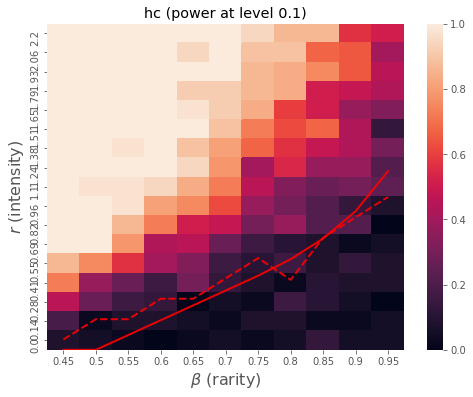

log_rank: both sides detected in 0.3590114178349472 of cases
(you should be worried if this number is significantly larger than 0.025)


/usr/local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


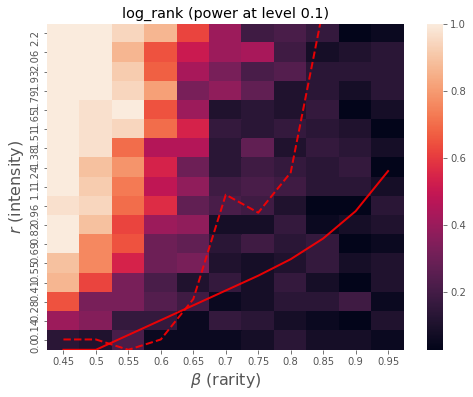

In [179]:
out_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/Figs/"
out_filename = out_dir + 'phase_diagram_'
#def illustrate_phase_diagrams(df1, df0, out_filename='phase_diagram'):
"""

Args:
-----
:df1:   results from experiments under alternative 
:df0:   results from experiments under null
:out_filename:   file/path name to write to
"""

params = ['itr', 'T', 'N1', 'N2', 'r', 'beta']
tests = ['hc', 'log_rank'] #, 'min_p', 'berk_jones', 'wilcoxon', 'fisher']
tests_vars = [c for c in df0.columns if c not in params and 'Unnamed' not in c]

global_params = ['T', 'N1', 'N2']
level = 0.1
tcrit = df0.groupby(global_params).agg(lambda x : quantile(x, 1-level))

level_bin = 0.05

good_side = 'greater'
bad_side = 'less'


for c in df1.groupby(global_params):
    print(f"Analyzing the case (T, N1, N2) = {c[0]}")
    dfc = c[1]

    for tsn in tests:
        name_good = tsn + '_' + good_side
        name_bad = tsn + '_' + bad_side

        # we check rate when both sides succedds. These are not good outcomes
        two_side_succ = ( dfc[name_good] > tcrit[name_good].values[0] ) & ( dfc[name_bad] > tcrit[name_bad].values[0] )
        print(f"{tsn}: both sides detected in {np.mean(two_side_succ)} of cases")
        print("(you should be worried if this number is significantly larger than 0.025)")

        bb = dfc['beta'].unique()
        rr = dfc['r'].unique()
        
        def r2grid(r):
            return len(rr) / (rr.max() - rr.min()) * (rr.max() - r)
        
        def b2grid(b):
            return len(bb) / (bb.max() - bb.min()) * (b - bb.min())
        
        
        rcrit = np.zeros_like(bb)
        bcrit = np.zeros_like(rr)
        
        mat = compute_power(dfc.rename(columns={name_good : 'value'}), tcrit[name_good].values[0])
                   
        for j,r in enumerate(rr):
            empirical_power = mat[:,j]
            binom_pvals = binom_test(empirical_power * nMonte,
                                    np.array(nMonte), level, alt='greater')
            substentiality_indicator_beta = binom_pvals < level_bin
            bc = sigmoid_intercept(bb, substentiality_indicator_beta)
            bcrit[j] = np.minimum(np.maximum(bc, 0.55), 1)
            
        for i,beta in enumerate(bb):
            empirical_power = mat[i,:]
            binom_pvals = binom_test(empirical_power * nMonte,
                                    np.array(nMonte), level, alt='greater')
            substentiality_indicator_r = binom_pvals < level_bin
            if substentiality_indicator_r[-1] == False:
                rcrit[i] = 100
            elif np.sum(substentiality_indicator_r) == 0:
                rcrit[i] = 100
            else:
                rc = sigmoid_intercept(rr, substentiality_indicator_r)
                rcrit[i] = np.minimum(np.maximum(rc, 0), 2.3)
            

        plt.figure()
        
        g = seaborn.heatmap(mat[:,::-1].T)
        plt.title(f"{tsn} (power at level {level})")
        g.set_xticklabels(bb)
        g.set_xlabel(r'$\beta$ (rarity)', fontsize=16)
        g.set_ylabel(r'$r$ (intensity)', fontsize=16)
        g.set_yticklabels(np.round(rr[::-1],2))
        
        g.plot(np.arange(len(bb))+.5, r2grid(rcrit), '--r', linewidth=2, alpha = .9)
        #g.plot(b2grid(bcrit[::-1])+ .5, np.arange(len(rr)), '--b', linewidth=2, alpha = .9)        
        g.plot(np.arange(len(bb))+.5, r2grid(2*rhos(bb)), 'r', linewidth=2, alpha=.9)
        
        fn = out_filename + tsn + ".png"
        plt.savefig(fn)
        plt.show()
        

17

In [188]:
dfr

NameError: name 'dfr' is not defined

In [151]:
substentiality_indicator_r

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False])

In [152]:
sum (ai - m)/ai = 0
T = m sum( 1 / ai)
m = 1 / sum( 1 / ai)


0.95

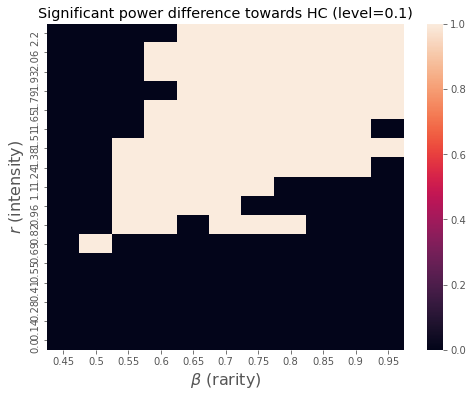

In [185]:
mat_lr = compute_power(df1.rename(columns={'log_rank_greater' : 'value'}), tcrit['log_rank_greater'].values[0])
mat_hc = compute_power(df1.rename(columns={'hc_greater' : 'value'}), tcrit['hc_greater'].values[0])

dmat = (mat_hc - mat_lr)

mat_sig_hc = dmat * np.sqrt(nMonte) > 2
mat_sig_lr = dmat * np.sqrt(nMonte) < -2

g = seaborn.heatmap(mat_sig_hc[:,::-1].T)

g.set_xticklabels(bb)
g.set_xlabel(r'$\beta$ (rarity)', fontsize=16)
g.set_ylabel(r'$r$ (intensity)', fontsize=16)
g.set_yticklabels(np.round(rr[::-1],2))
plt.title(f"Significant power difference towards HC (level={level})")

plt.savefig(out_dir + "sig_power_diff_HC.png")

plt.show()




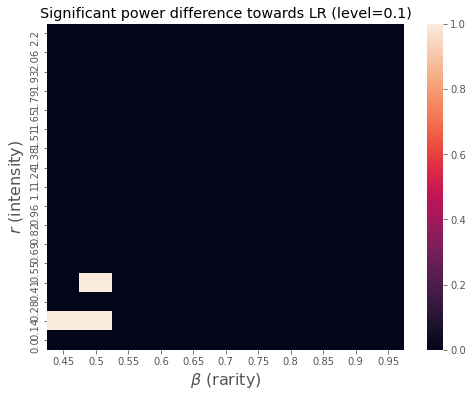

In [186]:
mat_lr = compute_power(df1.rename(columns={'log_rank_greater' : 'value'}), tcrit['log_rank_greater'].values[0])
mat_hc = compute_power(df1.rename(columns={'hc_greater' : 'value'}), tcrit['hc_greater'].values[0])

dmat = (mat_lr - mat_hc)

mat_sig_hc = dmat * np.sqrt(nMonte) > 2
mat_sig_lr = dmat * np.sqrt(nMonte) < -2

g = seaborn.heatmap(mat_sig_hc[:,::-1].T)

g.set_xticklabels(bb)
g.set_xlabel(r'$\beta$ (rarity)', fontsize=16)
g.set_ylabel(r'$r$ (intensity)', fontsize=16)
g.set_yticklabels(np.round(rr[::-1],2))
plt.title(f"Significant power difference towards LR (level={level})")
plt.savefig(out_dir + "sig_power_diff_LR.png")
plt.show()




## Check phase transition curves
For verifying theoretic result and comparing balanced vs. non-balanced

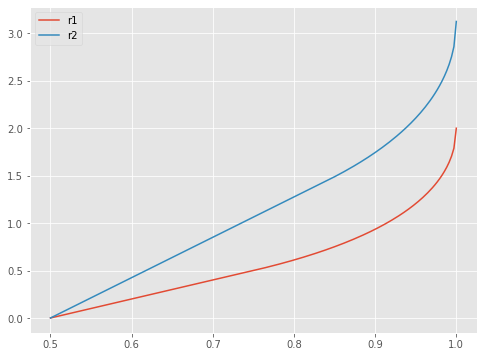

In [609]:
bb = np.linspace(0.5, 1, 171)

def rhos(be, sigma):
    if sigma**2 < 2:
        if be < 1 - sigma**2/4:
            return (2-sigma**2) * (be - 1/2)
        else:
            return (1-sigma*np.sqrt(1- be))**2
    else:
        if be < 1 - 1/sigma**2:
            return 0
        else:
            return (1-sigma*np.sqrt(1- be))**2

        
def plot_PT(r, sig):
    bb = np.linspace(0.5, 1, 171)
    rr = [rhos(b, sig) / r for b in bb]
    plt.plot(bb, rr)

            
kappa = 1/5

kappa_bar = 1 - kappa

r1 = 1 / 2
sig1 = 1

plot_PT(r1, sig1)

r2 = 2 * kappa * kappa_bar
sig2 = np.sqrt(4 * kappa * kappa_bar)

plot_PT(r2, sig2)

plt.legend(['r1', 'r2'])
plt.show()

In [347]:
from sample_poisson_data import *

<ipython-input-356-6c2616cdd073>:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(xx, np.log(xx))
<ipython-input-356-6c2616cdd073>:4: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(xx, -1 / xx)


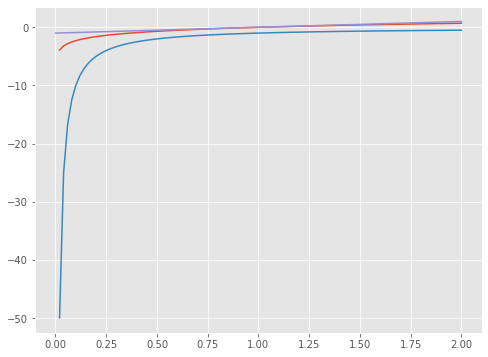

In [356]:
xx = np.linspace(0, 2, 101)

plt.plot(xx, np.log(xx))

0plt.plot(xx, -1 / xx)
plt.plot(xx, xx - 1)


## Illustrate Curves

In [207]:
from survival import evaluate_test_stats, multi_pvals

In [492]:
def find_changes(Nt1, Nt2, Ot1, Ot2, stbl=False, gamma=.35):
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    mt = MultiTest(pvals[pvals<=1], stbl=stbl) 
    hc, hct = mt.hc(gamma=gamma)
    return pvals <= hct

def illustrate_survival_curve(df, T, changes=True, stbl=True):
    dfg = df
    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['events1'].values, dfg['events2'].values
    
    stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=stbl, randomize=False)
    stats_rev = evaluate_test_stats(Nt2, Nt1, Ot2, Ot1, stbl=stbl, randomize=False)    
        
    print("HC (evaluate_test_stats) = ", stats['hc_greater'])
    
    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['events1'].values, dfg['events2'].values
    
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    pvals_rev = multi_pvals(Nt2, Nt1, Ot2, Ot1, randomize=False)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) # if not using stbl=False, then sometimes
    mt_rev = MultiTest(pvals_rev[pvals_rev<1], stbl=stbl)
    hc, hct = mt.hc(gamma=.35)
    hc_rev, _ = mt_rev.hc(gamma=.35)
    print("HC = ", hc)
    print("HC_rev = ", hc_rev)
        
    dfg['pvalue'] = pvals
    dfg['pvalue_rev'] = pvals_rev
    dfg['Survival Proportion X'] = dfg['at-risk1'] / dfg['at-risk1'].max()
    dfg['Survival Proportion Y'] = dfg['at-risk2'] / dfg['at-risk2'].max()
    #dfg['censored1'] = dfg['at-risk1'] - dfg['']
        
        
    plt.step(dfg.index, dfg['Survival Proportion X'], 'b', where='post')
    plt.step(dfg.index, dfg['Survival Proportion Y'], 'r', where='post')
    
    plt.legend([r'$X$', r'$Y$'], fontsize=16, loc=1)
    
    if changes:
        fpval = find_changes(Nt1, Nt2, Ot1, Ot2,
                         stbl=stbl)
        plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2, width=.25)
        df_disp = dfg[fpval].rename(columns={'at-risk1' : 'at-risk X',
                                                 'at-risk2' : 'at-risk Y',
                                     'events1' : 'events X', 'events2' : 'events Y'
                                    })

    plt.title(f"HC={np.round(stats['hc_greater'],2)}, Log-rank={np.round(stats['log_rank_greater'],2)}")
    plt.ylabel('Survival Proportion', fontsize=16)
    plt.xlabel(r'Time', fontsize=16)
    
    return df_disp, dfg


In [490]:
remote_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/"

HC (evaluate_test_stats) =  2.3208328375725817
HC =  2.3711323090093406
HC_rev =  -0.7409408064673819


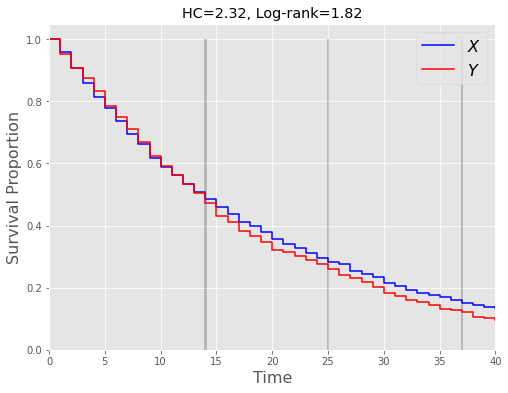

In [493]:
T = 40
N1 = 1000
N2 = 1000
eps = 0.1
lam0 = 2 / T * np.ones(T)
r = 2
Nt1, Nt2 = sample_survival_data(T, N1, N2, lam0, eps, r)
Ot1 = np.append(-np.diff(Nt1), 0)
Ot2 = np.append(-np.diff(Nt2), 0)

df = pd.DataFrame({
    'at-risk1': Nt1,
    'at-risk2': Nt2,
    'events1': Ot1,
    'events2': Ot2
})

df1, df2 = illustrate_survival_curve(df, T=100, stbl=False)
#plt.title("Hi")
plt.xlim((0,T))
#plt.xtickslabel(fontsize=16)
plt.savefig(remote_dir + 'Figs/survival_curve_exm.png')
plt.show()

In [495]:
dfs = df2.copy()
dfs.index.name='time'

for c in ['at-risk1', 'at-risk2', 'events1', 'events2']:
    dfs[c] = dfs[c].astype(int)
    
dfs['pvalue'] = np.round(dfs['pvalue'], 5)
    
dfs[:-1].filter(['at-risk1', 'at-risk2', 'events1', 'events2', 'pvalue'])\
.to_csv(remote_dir + 'csv/survival_curve_exm.csv')
dfs[:-1]

,at-risk1,at-risk2,events1,events2,pvalue,pvalue_rev,Survival Proportion X,Survival Proportion Y
time,,,,,,,,
0,1000,1000,42,49,0.25996,0.804604,1.000,1.000
1,958,951,52,44,0.81741,0.243248,0.958,0.951
2,906,907,46,31,0.96946,0.050702,0.906,0.907
3,860,876,46,42,0.73750,0.338363,0.860,0.876
4,814,834,35,48,0.10766,0.928615,0.814,0.834
5,779,786,43,38,0.76599,0.309412,0.779,0.786
6,736,748,42,37,0.77860,0.295901,0.736,0.748
7,694,711,33,42,0.20006,0.859799,0.694,0.711
8,661,669,44,46,0.48013,0.605661,0.661,0.669


In [496]:
df1

,at-risk X,at-risk Y,events X,events Y,pvalue,pvalue_rev,Survival Proportion X,Survival Proportion Y
14,485.0,472.0,25.0,42.0,0.015815,0.991935,0.485,0.472
25,283.0,260.0,8.0,18.0,0.020541,0.993012,0.283,0.260
37,150.0,123.0,7.0,16.0,0.012122,0.996556,0.150,0.123


In [353]:
df2.pvalue.min()

0.0